<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/LLMS/Synthetic_Data_with_LLMs_D1_D2_80_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model,Input
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, make_scorer
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
import shap
from sklearn.mixture import GaussianMixture
from joblib import dump
from joblib import load


import warnings
warnings.filterwarnings('ignore')

In [ ]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

In [ ]:
pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                          

### Functions

In [ ]:
def compare_real_vs_synthetic(real_df, synthetic_df, columns=None, kind='hist', bins=30, figsize=(15, 10)):
    """
    Compare distributions between real and synthetic datasets.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - columns: list of column names to compare; if None, all columns are used
    - kind: str, type of plot: 'hist', 'kde', or 'box'
    - bins: int, number of bins for histograms
    - figsize: tuple, size of the plot figure

    Returns:
    - None (displays plots)
    """
    if columns is None:
        columns = [col for col in real_df.columns if real_df[col].dtype != 'object']

    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    plt.figure(figsize=figsize)

    for idx, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, idx)

        if kind == 'hist':
            sns.histplot(real_df[col], color='blue', label='Real', kde=False, stat='density', bins=bins, alpha=0.6)
            sns.histplot(synthetic_df[col], color='red', label='Synthetic', kde=False, stat='density', bins=bins, alpha=0.6)

        elif kind == 'kde':
            sns.kdeplot(real_df[col], color='blue', label='Real')
            sns.kdeplot(synthetic_df[col], color='red', label='Synthetic')

        elif kind == 'box':
            sns.boxplot(data=[real_df[col], synthetic_df[col]], palette=['blue', 'red'])
            plt.xticks([0, 1], ['Real', 'Synthetic'])

        else:
            raise ValueError("Unsupported plot kind. Choose from 'hist', 'kde', or 'box'.")

        plt.title(f"Comparison for '{col}'")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def pca_visual_comparison_3d(real_df, synthetic_df, color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D PCA projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for coloring points (must exist in both datasets)
    - title_suffix: str, suffix to append to plot title

    Returns:
    - None (displays PCA 3D scatter plot)
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    features = combined_df.drop(columns=[color_by]) if color_by else combined_df
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # Fit PCA (3 components for 3D)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(combined_scaled)
    dump(pca, f'pca_model_{var}_llm_80.pkl')
    dump(scaler, f'scaler_pca_model_{var}_llm_80.pkl')

    # Separate PCA results
    n_real = len(real_df)
    real_pca = pca_result[:n_real]
    synth_pca = pca_result[n_real:]

    # Prepare figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real data
    ax.scatter(real_pca[:, 0], real_pca[:, 1], real_pca[:, 2],
               c='blue', label='Real', s=40, alpha=0.6, edgecolor='k')

    # Plot synthetic data
    ax.scatter(synth_pca[:, 0], synth_pca[:, 1], synth_pca[:, 2],
               c='red', label='Synthetic', s=40, alpha=0.6, edgecolor='k')

    ax.set_title(f"3D PCA: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.grid(False)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def umap_visual_comparison_3d(real_df, synthetic_df, n_neighbors=15, min_dist=0.1, metric='euclidean', color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D UMAP projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for color grouping
    - title_suffix: str, optional title suffix

    Returns:
    - None
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine datasets for scaling
    combined_df = pd.concat([real_df, synthetic_df])
    if color_by and color_by in combined_df.columns:
        features = combined_df.drop(columns=[color_by])
    else:
        features = combined_df

    # Normalize features
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # UMAP transformation
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,
        metric=metric,
        random_state=42
    )
    umap_result = reducer.fit_transform(combined_scaled)
    dump(reducer, f'umap_model_{var}_llm_80.pkl')
    dump(scaler, f'scaler_umap_model_{var}_llm_80.pkl')


    # Separate results
    n_real = len(real_df)
    real_umap = umap_result[:n_real]
    synth_umap = umap_result[n_real:]

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real and synthetic points and store the artists
    real_plot = ax.scatter(real_umap[:, 0], real_umap[:, 1], real_umap[:, 2],
                           c='blue', s=40, alpha=0.6, edgecolor='k', label='Real')

    synth_plot = ax.scatter(synth_umap[:, 0], synth_umap[:, 1], synth_umap[:, 2],
                            c='red', s=40, alpha=0.6, edgecolor='k', label='Synthetic')

    # Titles and labels
    ax.set_title(f"3D UMAP: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")

    # Manual legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


In [ ]:
def run_glm_frequency_analysis(
    X_train, X_test, model=None, clip_exposure=False, random_state=0, label="Model"
):
    """
    Run GLM Poisson regression frequency analysis (ClaimNb ~ Features | Exposure).

    Parameters:
    - X_train: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - X_test: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - model: sklearn regressor, default is TweedieRegressor(power=1, link='log')
    - clip_exposure: bool, if True, caps Exposure at 1 in training set
    - random_state: int, for reproducibility
    - label: str, label for printing/logging

    Returns:
    - trained_model: fitted model
    - results: dict with CV scores, deviance on train/test, and predictions
    """

    np.random.seed(0)

    # Optionally clip exposure in training data
    if clip_exposure:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    # Filter for Exposure > 0
    mask_tr = X_train['Exposure'] > 0
    mask_te = X_test['Exposure'] > 0
    X_train_f = X_train[mask_tr].copy()
    X_test_f = X_test[mask_te].copy()

    y_train = X_train_f['ClaimNb']
    y_test = X_test_f['ClaimNb']
    exposure_train = X_train_f['Exposure']
    exposure_test = X_test_f['Exposure']

    X_train_ = X_train_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
    X_test_ = X_test_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

    # Set model if not passed
    if model is None:
        model = TweedieRegressor(power=1, link='log')

    # Cross-validation
    cv = KFold(n_splits=5)
    mpd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = exposure_train.iloc[train_idx], exposure_train.iloc[val_idx]

        model.fit(X_tr, y_tr / w_tr, sample_weight=w_tr)
        y_pred = model.predict(X_val)

        score = mean_poisson_deviance(y_val / w_val, y_pred)
        print(f"Fold {fold_idx + 1} Poisson Deviance Score: {score:.4f}")
        mpd_scores.append(score)

    print(f"Average cross-validation Poisson Deviance Score: {np.mean(mpd_scores):.4f}")
    print(f"Standard Deviation of CV Scores: {np.std(mpd_scores):.4f}")

    # Final fit on full training set
    model.fit(X_train_, y_train / exposure_train, sample_weight=exposure_train)

    pred_train = model.predict(X_train_)
    pred_test = model.predict(X_test_)

    mpd_train = mean_poisson_deviance(y_train / exposure_train, pred_train)
    mpd_test = mean_poisson_deviance(y_test / exposure_test, pred_test)

    print(f"Train Poisson Deviance: {mpd_train:.4f}")
    print(f"Test Poisson Deviance: {mpd_test:.4f}")

    return model, {
        "cv_scores": mpd_scores,
        "mpd_train": mpd_train,
        "mpd_test": mpd_test,
        "train_predictions": pred_train,
        "test_predictions": pred_test
    }


In [ ]:
def run_glm_cost_analysis(X_train, X_test, is_sampled=False, verbose=True):
    """
    Perform GLM Cost Analysis using Tweedie Regressor (power=2, link='log').

    Parameters:
    - X_train: Training DataFrame (must include 'ClaimAmount', 'ClaimNb', 'Exposure')
    - X_test: Testing DataFrame
    - is_sampled: If True, cap 'Exposure' at 1 for training data
    - verbose: If True, print CV results and scores

    Returns:
    - Dictionary containing train/test gamma deviance and predictions
    """
    np.random.seed(0)

    # Cap exposure if sampled
    if is_sampled:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    X_train_co = X_train.copy()
    X_test_co = X_test.copy()

    # Compute average cost per claim (Acost)
    X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0,
                                   X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
    X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0,
                                  X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

    # Filter rows with non-zero claim amounts
    X_train_cost = X_train_co[X_train_co['ClaimAmount'] != 0].copy()
    X_test_cost = X_test_co[X_test_co['ClaimAmount'] != 0].copy()

    # Target and weights
    y_train = X_train_cost['Acost']
    claim_tr = X_train_cost['ClaimNb']
    y_test = X_test_cost['Acost']
    claim_te = X_test_cost['ClaimNb']

    # Features
    drop_cols = ['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb']
    X_train_ = X_train_cost.drop(columns=drop_cols)
    X_test_ = X_test_cost.drop(columns=drop_cols)

    # Initialize model
    glm_cl = TweedieRegressor(power=2, link='log')

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    mgd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = claim_tr.iloc[train_idx], claim_tr.iloc[val_idx]

        glm_cl.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred_val = glm_cl.predict(X_val)
        score = mean_gamma_deviance(y_val, y_pred_val)
        mgd_scores.append(score)

        if verbose:
            print(f"Fold {fold_idx + 1} Gamma Deviance Score: {score:.4f}")

    if verbose:
        print("Average cross-validation Gamma Deviance Score:", np.mean(mgd_scores))
        print("Standard Deviation of CV Scores:", np.std(mgd_scores))

    # Train on full data
    glm_cl.fit(X_train_, y_train, sample_weight=claim_tr)

    # Predictions
    y_pred_train = glm_cl.predict(X_train_)
    y_pred_test = glm_cl.predict(X_test_)

    # Deviance on train and test
    mgd_train = mean_gamma_deviance(y_train, y_pred_train)
    mgd_test = mean_gamma_deviance(y_test, y_pred_test)

    if verbose:
        print(f"Train Gamma Deviance: {mgd_train:.4f}")
        print(f"Test Gamma Deviance: {mgd_test:.4f}")

    return {
        "cv_scores": mgd_scores,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


In [ ]:
def plot_glm_shap_importance(
    X_train, X_test, y_train, sample_weight,
    power: int, title: str, max_display: int = 10, figsize: tuple = (5, 5), seed: int = 0
):
    """
    Compute and plot SHAP feature importance for GLMs using SHAP LinearExplainer.

    Parameters:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Test features
        y_train (pd.Series or np.array): Training target
        sample_weight (pd.Series or np.array): Sample weights
        power (int): Tweedie power (1 = Poisson for frequency, 2 = Gamma for severity)
        title (str): Title for the plot
        max_display (int): Max number of features to display
        figsize (tuple): Size of the figure
        seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)

    model = TweedieRegressor(power=power, link='log')
    model.fit(X_train, y_train, sample_weight=sample_weight)

    masker = shap.maskers.Independent(X_train)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer.shap_values(X_test)

    plt.rcParams['figure.figsize'] = figsize
    shap.summary_plot(
        shap_values, features=X_test,
        feature_names=X_test.columns,
        plot_type='bar',
        max_display=max_display,
        show=False
    )
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


### Upload dataset and data handling

In [ ]:
#-------------------
# D1
#-------------------
df1=pd.read_csv('/content/ausprivauto0405.csv')

In [ ]:
print(df1.shape)

(67856, 9)


In [ ]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [ ]:
print(df1.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [ ]:
df1.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [ ]:
df1_duplicated_rows=df1[df1.duplicated()]
df1_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [ ]:
df1=df1.drop_duplicates()

In [ ]:
df1_duplicated_col=df1.columns[df1.columns.duplicated()]
df1_duplicated_col

Index([], dtype='object')

In [ ]:
missing=df1.isnull().sum()/df1.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [ ]:
print(df1['VehAge'].unique())
print(df1['DrivAge'].unique())
print(df1['VehBody'].unique())
print(df1['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [ ]:
df1_encod=df1.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df1_encod['VehAge'] = df1_encod['VehAge'].map(VehAge_group)
df1_encod['VehAge']= df1_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df1_encod['DrivAge'] = df1_encod['DrivAge'].map(DrivAge_group)
df1_encod['DrivAge']= df1_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df1_encod['VehBody'] = df1_encod['VehBody'].map(VehBody_group)
df1_encod['VehBody']= df1_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df1_encod['Gender'] = df1_encod['Gender'].map(Gender_group)
df1_encod['Gender']= df1_encod['Gender'].astype(int)




In [ ]:
df1_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [ ]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df1_encod, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(53320, 9)

### Use Generate Samples Dataframe from GPT-5

In [ ]:
df1_synth = pd.read_csv('/content/synthetic_nonlife_53320_D1_80.csv')


In [ ]:
df1_synth.columns

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')

In [ ]:
df1_synth_encod=df1_synth.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df1_synth_encod['VehAge'] = df1_synth_encod['VehAge'].map(VehAge_group)
df1_synth_encod['VehAge']= df1_synth_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df1_synth_encod['DrivAge'] = df1_synth_encod['DrivAge'].map(DrivAge_group)
df1_synth_encod['DrivAge']= df1_synth_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df1_synth_encod['VehBody'] = df1_synth_encod['VehBody'].map(VehBody_group)
df1_synth_encod['VehBody']= df1_synth_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df1_synth_encod['Gender'] = df1_synth_encod['Gender'].map(Gender_group)
df1_synth_encod['Gender']= df1_synth_encod['Gender'].astype(int)


In [ ]:
new_samples_df=df1_synth_encod.copy()

### Data Comparison

In [ ]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [ ]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.464703,0.288373,0.002738,0.210044,0.450718,0.710429,0.999316
VehValue,53320.0,1.784108,1.511749,0.000000,0.833173,1.385955,2.255521,25.964339
VehAge,53320.0,2.371793,1.128892,1.000000,1.000000,2.000000,3.000000,4.000000
VehBody,53320.0,6.727288,3.221889,1.000000,5.000000,6.000000,9.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.000000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.181770,1.683729,1.000000,2.000000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.071343,0.257399,0.000000,0.000000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.075506,0.280328,0.000000,0.000000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,781.697354,0.000000,0.000000,0.000000,0.000000,24431.101469


In [ ]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49516
Records where all three are positive: 3804


In [ ]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [Exposure, VehValue, VehAge, VehBody, Gender, DrivAge, ClaimOcc, ClaimNb, ClaimAmount]
Index: []


### Visual Comparison

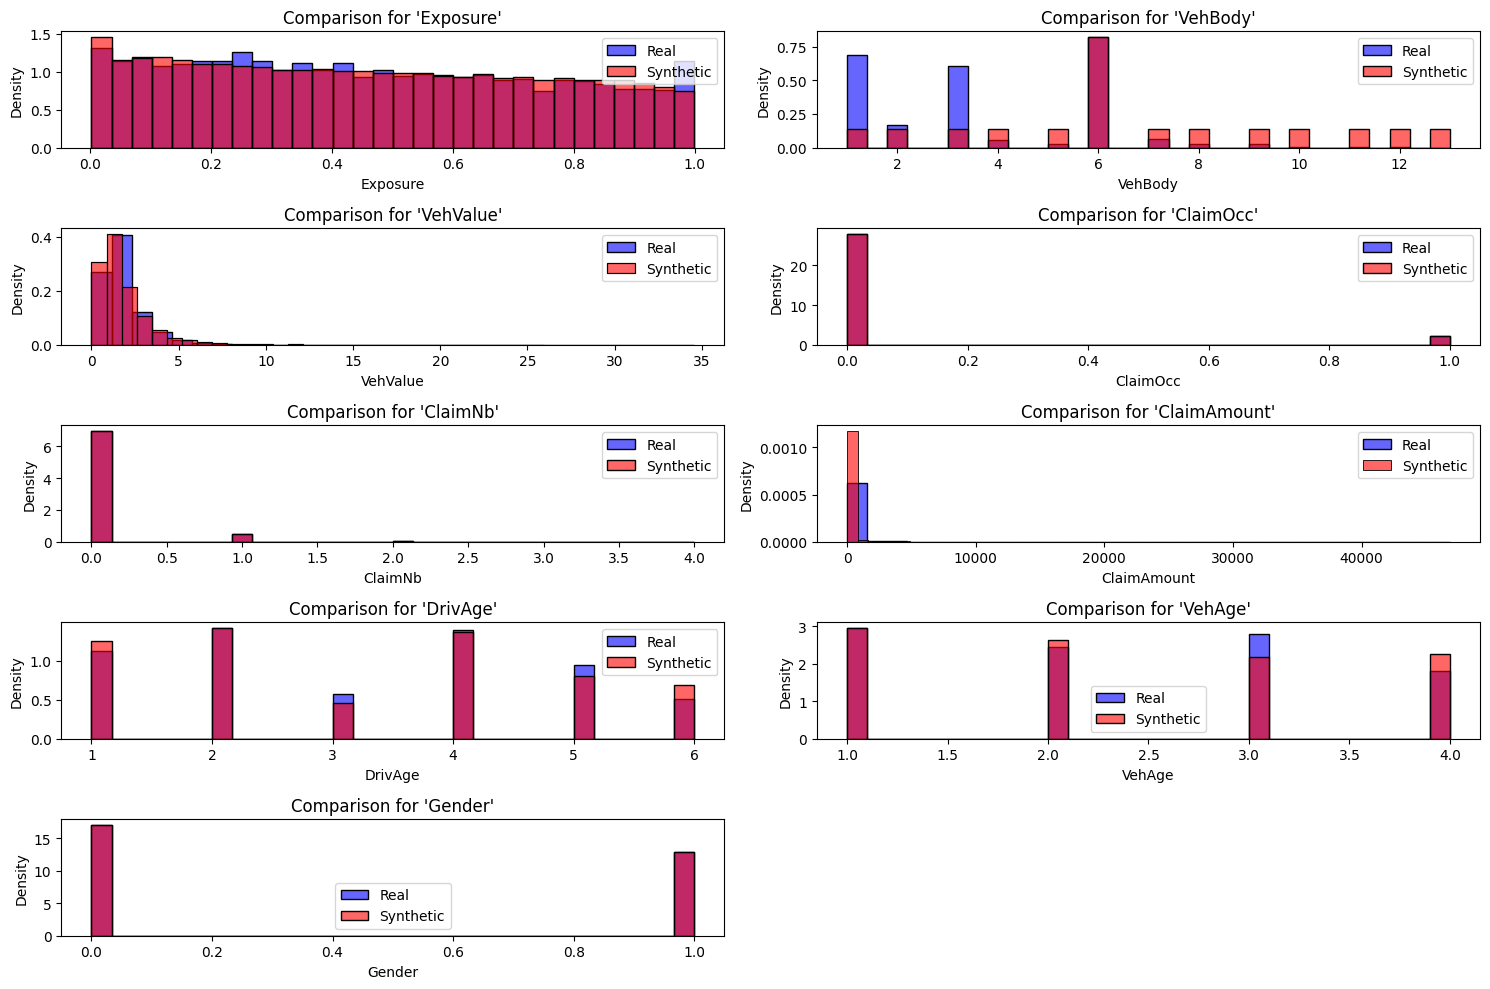

In [ ]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=new_samples_df,
    columns=['Exposure','VehBody','VehValue','ClaimOcc','ClaimNb', 'ClaimAmount', 'DrivAge', 'VehAge','Gender'],
    kind='hist'
)


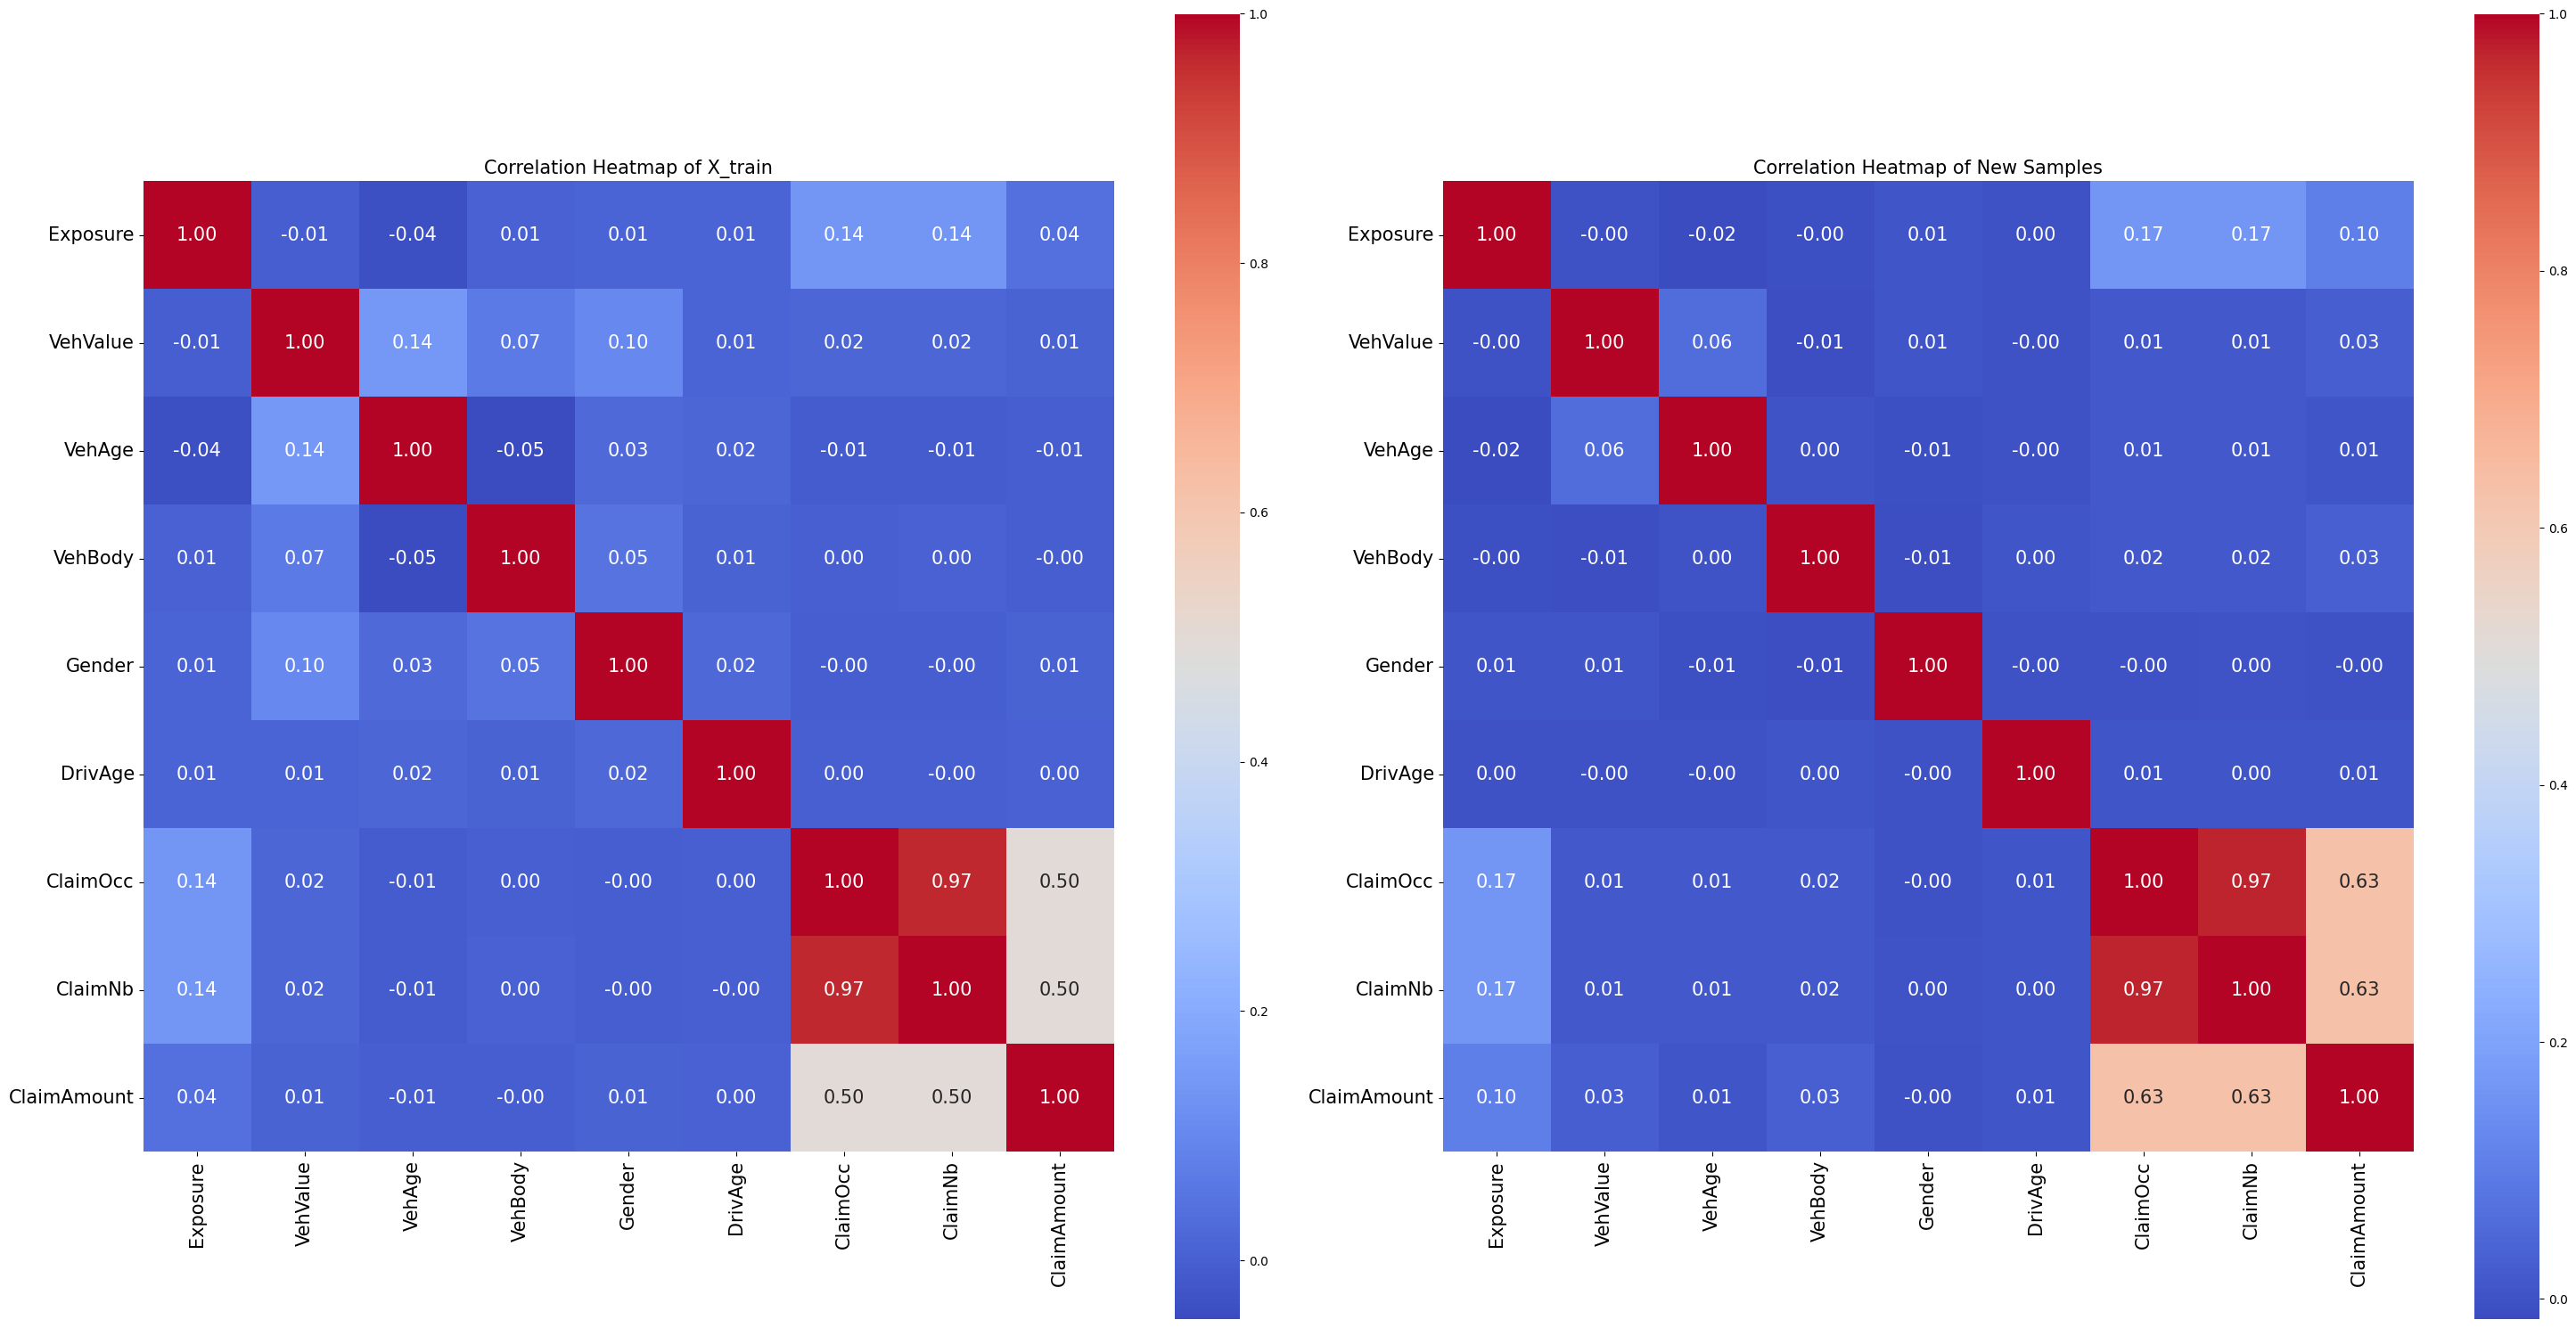

In [ ]:
# Compute correlation matrices
corr_matrix_X_train = X_train.corr()
corr_matrix_new_samples = new_samples_df.corr()

# Set figure size
plt.figure(figsize=(30,15))

# a subplot grid
# Parameters (1, 2, 1) implies 1 row, 2 columns, and this plot is the 1st plot.
plt.subplot(1, 2, 1) # Subplot 1
sns.heatmap(corr_matrix_X_train, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of X_train', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# another subplot for the second heatmap
plt.subplot(1, 2, 2) # Subplot 2
sns.heatmap(corr_matrix_new_samples, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of New Samples', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()

### Statistical Analysis

In [ ]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.013972243060765166, P-value=5.971937015782109e-05
KS Test for VehValue: Statistic=0.0961927981995499, P-value=3.6559927585709325e-215
KS Test for VehAge: Statistic=0.04401725431357839, P-value=2.5293264615079267e-45
KS Test for VehBody: Statistic=0.41691672918229555, P-value=0.0
KS Test for Gender: Statistic=0.0, P-value=1.0
KS Test for DrivAge: Statistic=0.02878844711177786, P-value=1.2523560091124747e-19
KS Test for ClaimOcc: Statistic=0.0018942235558889742, P-value=0.9999779845695164
KS Test for ClaimNb: Statistic=0.0018942235558889742, P-value=0.9999779845695164
KS Test for ClaimAmount: Statistic=0.009602400600150052, P-value=0.014556124466283762


### PCA Analysis

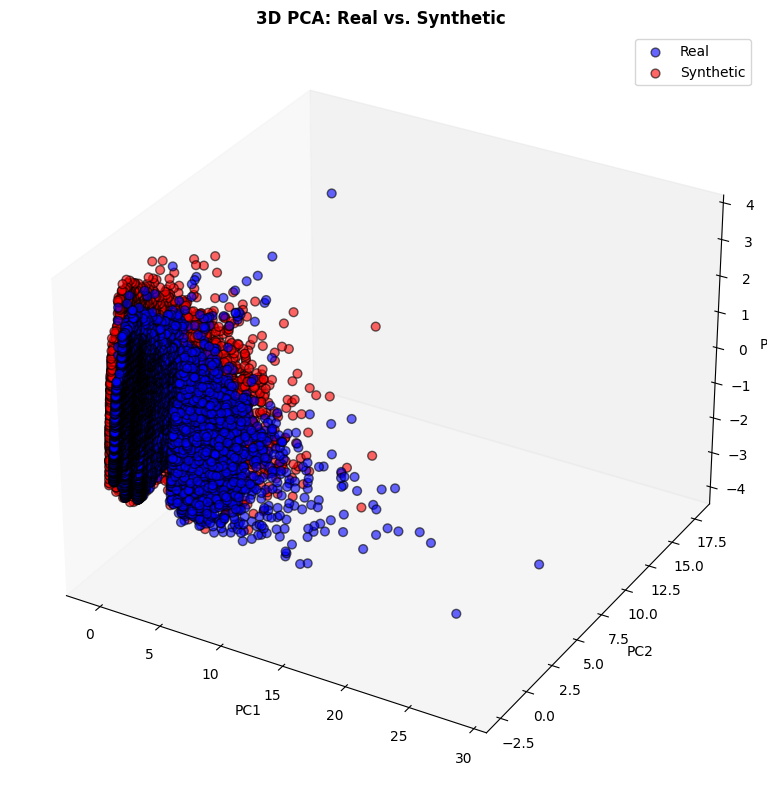

In [ ]:
pca_visual_comparison_3d(X_train, new_samples_df, var='d1')

### UMAP Analysis

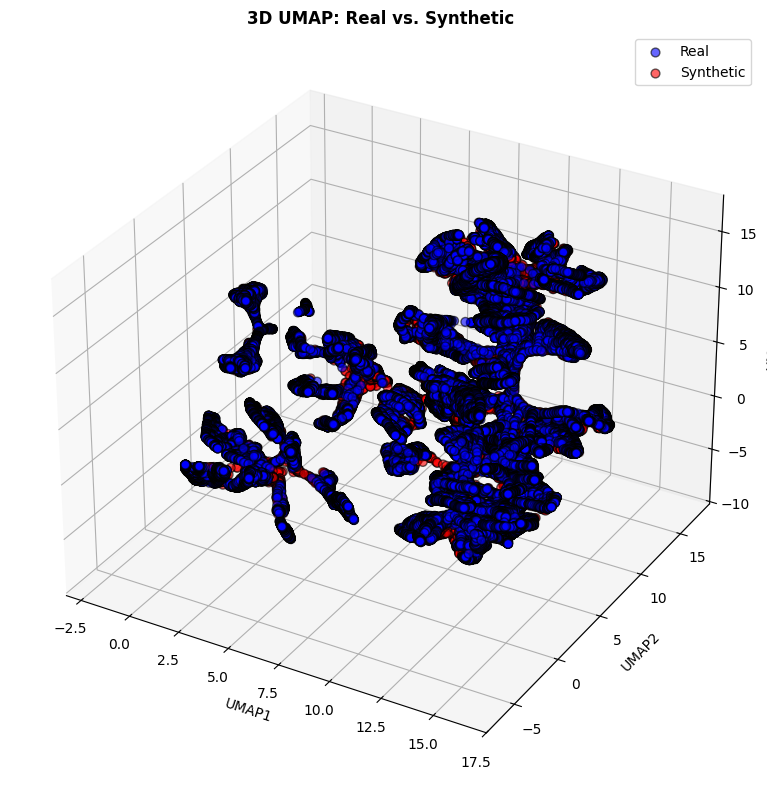

In [ ]:
umap_visual_comparison_3d(X_train, new_samples_df, var='d1')

### GLM Frequency Analysis

In [ ]:
# Baseline frequency model
results_frequency_1 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")



Fold 1 Poisson Deviance Score: 1.6448
Fold 2 Poisson Deviance Score: 1.3600
Fold 3 Poisson Deviance Score: 1.0406
Fold 4 Poisson Deviance Score: 1.8229
Fold 5 Poisson Deviance Score: 1.3053
Average cross-validation Poisson Deviance Score: 1.4347
Standard Deviation of CV Scores: 0.2729
Train Poisson Deviance: 1.4345
Test Poisson Deviance: 1.7412


In [ ]:
# Using synthetic sample data with exposure clipping
results_frequency_2 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 1.4043
Fold 2 Poisson Deviance Score: 0.9279
Fold 3 Poisson Deviance Score: 0.9117
Fold 4 Poisson Deviance Score: 1.0583
Fold 5 Poisson Deviance Score: 0.8694
Average cross-validation Poisson Deviance Score: 1.0343
Standard Deviation of CV Scores: 0.1954
Train Poisson Deviance: 1.0342
Test Poisson Deviance: 1.7410


### GLM Cost Analysis

In [ ]:
results_cost_1 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.5149
Fold 2 Gamma Deviance Score: 1.6084
Fold 3 Gamma Deviance Score: 1.4353
Fold 4 Gamma Deviance Score: 1.5815
Fold 5 Gamma Deviance Score: 1.6581
Average cross-validation Gamma Deviance Score: 1.5596604025666598
Standard Deviation of CV Scores: 0.07748353705257649
Train Gamma Deviance: 1.5509
Test Gamma Deviance: 1.7221


In [ ]:
results_cost_2 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)


Fold 1 Gamma Deviance Score: 1.4870
Fold 2 Gamma Deviance Score: 1.4928
Fold 3 Gamma Deviance Score: 1.5650
Fold 4 Gamma Deviance Score: 1.4973
Fold 5 Gamma Deviance Score: 1.5287
Average cross-validation Gamma Deviance Score: 1.5141444708623004
Standard Deviation of CV Scores: 0.029237979017121666
Train Gamma Deviance: 1.5110
Test Gamma Deviance: 1.7966


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


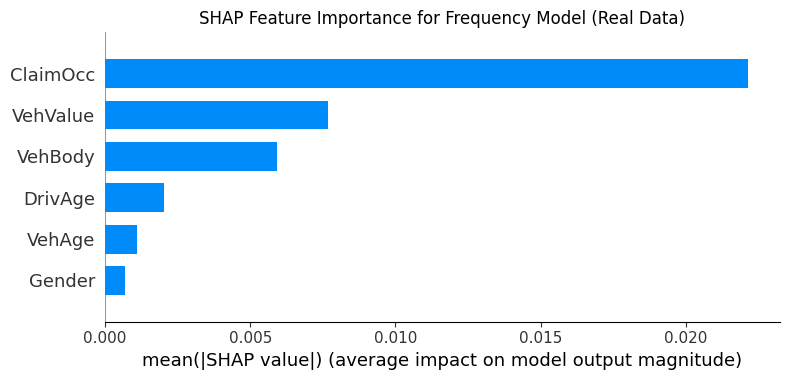


--- SHAP Feature Importance for Severity Model ---


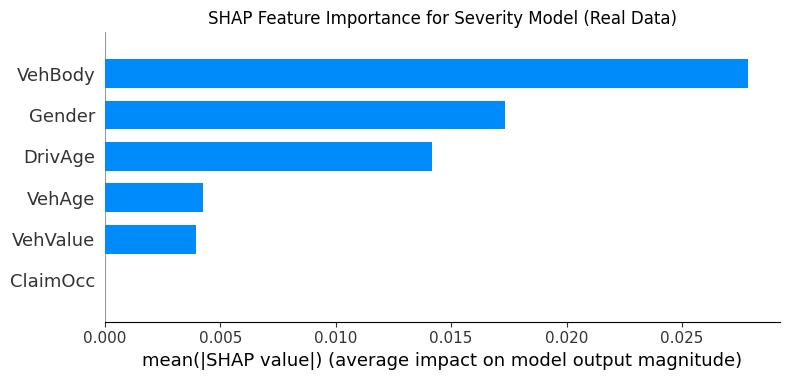

In [ ]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


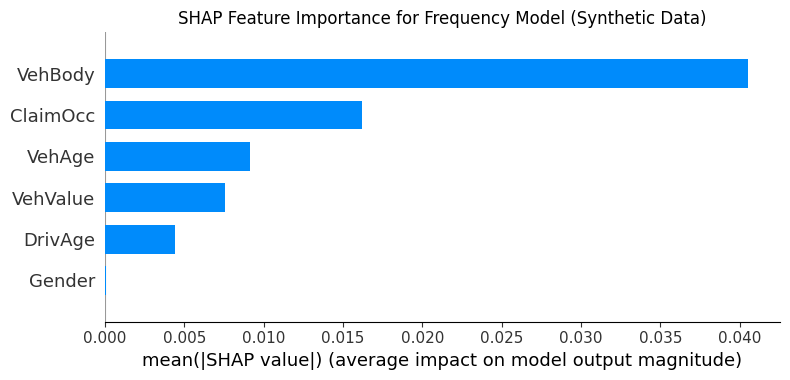


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


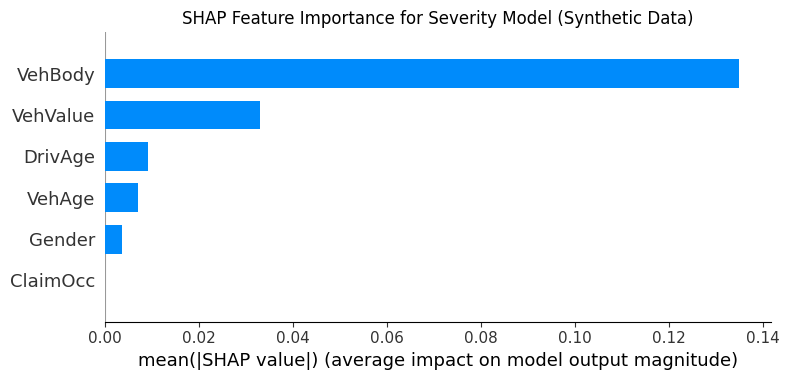

In [ ]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Upload dataset and data handling

In [ ]:
#---------------------
# D2
#---------------------
df2=pd.read_csv('/content/swmotorcycle.csv')

In [ ]:
print(df2.shape)

(64548, 9)


In [ ]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OwnerAge     64548 non-null  int64  
 1   Gender       64548 non-null  object 
 2   Area         64548 non-null  object 
 3   RiskClass    64548 non-null  object 
 4   VehAge       64548 non-null  int64  
 5   BonusClass   64548 non-null  object 
 6   Exposure     64548 non-null  float64
 7   ClaimNb      64548 non-null  int64  
 8   ClaimAmount  64548 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 4.4+ MB
None


In [ ]:
print(df2.columns)

Index(['OwnerAge', 'Gender', 'Area', 'RiskClass', 'VehAge', 'BonusClass',
       'Exposure', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [ ]:
df2.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0,0


In [ ]:
df2_duplicated_rows=df2[df2.duplicated()]
df2_duplicated_rows

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount


In [ ]:
df2=df2.drop_duplicates()

In [ ]:
df2_duplicated_col=df2.columns[df2.columns.duplicated()]
df2_duplicated_col

Index([], dtype='object')

In [ ]:
missing=df2.isnull().sum()/df2.shape[0]*100
missing

,0
OwnerAge,0.0
Gender,0.0
Area,0.0
RiskClass,0.0
VehAge,0.0
BonusClass,0.0
Exposure,0.0
ClaimNb,0.0
ClaimAmount,0.0


In [ ]:
# add ClaimOcc feature
df_2 = df2.copy()
df_2['ClaimOcc'] = np.where(df_2['ClaimNb'] > 0, 1, 0)
# Feature transformation
df_2['Exposure'] = df_2['Exposure'].clip(upper=1)
df_2['VehAge'] = df_2['VehAge'].clip(upper=20)

### Encoding

In [ ]:
print(df_2['Gender'].unique())
print(df_2['Area'].unique())
print(df_2['RiskClass'].unique())
print(df_2['BonusClass'].unique())


['Male' 'Female']
["Central parts of Sweden's three largest cities"
 'Lesser towns except Gotland; Northern towns'
 'Small towns; countryside except Gotland; Northern towns'
 'Suburbs; middle-sized cities' 'Northern countryside' 'Northern towns'
 "Gotland (Sweden's largest island)"]
['EV ratio 13-15' 'EV ratio 20-24' 'EV ratio 9-12' 'EV ratio <5'
 'EV ratio 6-8' 'EV ratio 16-19' 'EV ratio >25']
['BM1' 'BM2' 'BM3' 'BM4' 'BM7' 'BM5' 'BM6']


In [ ]:
df2_encod=df_2.copy()
# RiskClass
RiskClass_group = {'EV ratio 13-15':'1','EV ratio 20-24':'2','EV ratio 9-12':'3','EV ratio <5':'4','EV ratio 6-8':'5',\
                   'EV ratio 16-19':'6','EV ratio >25':'7'}
df2_encod['RiskClass'] = df2_encod['RiskClass'].map(RiskClass_group)
df2_encod['RiskClass']= df2_encod['RiskClass'].astype(int)
# BonusClass
BonusClass_group = {'BM1':'1','BM2':'2','BM3':'3','BM4':'4','BM5':'5','BM6':'6','BM7':'7'}
df2_encod['BonusClass'] = df2_encod['BonusClass'].map(BonusClass_group)
df2_encod['BonusClass']= df2_encod['BonusClass'].astype(int)
# Area
Area_group = {"Central parts of Sweden's three largest cities":'1','Lesser towns except Gotland; Northern towns':'2',\
              'Small towns; countryside except Gotland; Northern towns':'3','Suburbs; middle-sized cities':'4',\
              'Northern countryside':'5','Northern towns':'6',"Gotland (Sweden's largest island)":'7'}
df2_encod['Area'] = df2_encod['Area'].map(Area_group)
df2_encod['Area']= df2_encod['Area'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df2_encod['Gender'] = df2_encod['Gender'].map(Gender_group)
df2_encod['Gender']= df2_encod['Gender'].astype(int)




In [ ]:
df2_encod.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,0,1,1,1,12,1,0.175342,0,0,0
1,4,1,2,2,9,1,0.000000,0,0,0
2,5,0,2,3,18,1,0.454795,0,0,0
3,5,0,3,4,20,1,0.172603,0,0,0
4,6,0,4,4,20,1,0.180822,0,0,0


### Split dataset

In [ ]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df2_encod, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(51638, 10)

### Use Generate Samples Dataframe from GPT-5



In [ ]:
df2_synth = pd.read_csv('/content/synthetic_nonlife_51638_D2_80.csv')


In [ ]:
df2_synth.columns

Index(['OwnerAge', 'Gender', 'Area', 'RiskClass', 'VehAge', 'BonusClass',
       'Exposure', 'ClaimNb', 'ClaimAmount', 'ClaimOcc'],
      dtype='object')

In [ ]:
print(df2_synth['Area'].unique())


['Northern countryside'
 'Small towns; countryside except Gotland; Northern towns'
 'Suburbs; middle-sized cities'
 "Central parts of Sweden's three largest cities"
 "Gotland (Sweden's largest island)"
 'Lesser towns except Gotland; Northern towns' 'Northern towns']


In [ ]:
df2_synth_encod=df2_synth.copy()
# RiskClass
RiskClass_group = {'EV ratio 13-15':'1','EV ratio 20-24':'2','EV ratio 9-12':'3','EV ratio <5':'4','EV ratio 6-8':'5',\
                   'EV ratio 16-19':'6','EV ratio >25':'7'}
df2_synth_encod['RiskClass'] = df2_synth_encod['RiskClass'].map(RiskClass_group)
df2_synth_encod['RiskClass']= df2_synth_encod['RiskClass'].astype(int)
# BonusClass
BonusClass_group = {'BM1':'1','BM2':'2','BM3':'3','BM4':'4','BM5':'5','BM6':'6','BM7':'7'}
df2_synth_encod['BonusClass'] = df2_synth_encod['BonusClass'].map(BonusClass_group)
df2_synth_encod['BonusClass']= df2_synth_encod['BonusClass'].astype(int)
# Area
Area_group = {"Central parts of Sweden's three largest cities":'1','Lesser towns except Gotland; Northern towns':'2',\
              'Small towns; countryside except Gotland; Northern towns':'3','Suburbs; middle-sized cities':'4',\
              'Northern countryside':'5','Northern towns':'6',"Gotland (Sweden's largest island)":'7'}
df2_synth_encod['Area'] = df2_synth_encod['Area'].map(Area_group)
df2_synth_encod['Area']= df2_synth_encod['Area'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df2_synth_encod['Gender'] = df2_synth_encod['Gender'].map(Gender_group)
df2_synth_encod['Gender']= df2_synth_encod['Gender'].astype(int)


In [ ]:
new_samples_df=df2_synth_encod.copy()

### Data Comparison

In [ ]:
X_train.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
17537,32,1,4,2,10,4,0.668493,0,0,0
36594,46,1,4,6,16,3,1.000000,0,0,0
49674,53,0,1,6,14,2,0.495890,0,0,0
60665,62,1,2,3,14,3,0.498630,0,0,0
28321,42,1,4,3,15,2,0.961644,0,0,0


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,42.381250,12.979286,0.0,31.000000,44.000000,52.0,92.0
Gender,51638.0,0.848581,0.358461,0.0,1.000000,1.000000,1.0,1.0
Area,51638.0,2.973643,1.253283,1.0,2.000000,3.000000,4.0,7.0
RiskClass,51638.0,3.356714,1.747525,1.0,2.000000,3.000000,5.0,7.0
VehAge,51638.0,11.114722,6.365856,0.0,5.000000,12.000000,16.0,20.0
BonusClass,51638.0,4.020508,2.364091,1.0,2.000000,4.000000,7.0,7.0
Exposure,51638.0,0.687829,0.332135,0.0,0.463014,0.821918,1.0,1.0
ClaimNb,51638.0,0.010535,0.105824,0.0,0.000000,0.000000,0.0,2.0
ClaimAmount,51638.0,260.434583,4748.164398,0.0,0.000000,0.000000,0.0,365347.0
ClaimOcc,51638.0,0.010148,0.100224,0.0,0.000000,0.000000,0.0,1.0


In [ ]:
new_samples_df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,53,1,5,4,6,2,1.000000,0,0,0
1,56,1,3,6,1,7,0.844845,0,0,0
2,61,1,4,4,13,5,0.467853,0,0,0
3,25,1,3,5,12,6,0.453664,0,0,0
4,43,1,1,3,10,5,0.819805,0,0,0


In [ ]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,41.341977,12.866541,0.000000,32.00000,41.000000,50.0,91.0
Gender,51638.0,0.845443,0.361485,0.000000,1.00000,1.000000,1.0,1.0
Area,51638.0,3.713796,1.749197,1.000000,3.00000,3.000000,5.0,7.0
RiskClass,51638.0,3.805395,1.845104,1.000000,3.00000,3.000000,5.0,7.0
VehAge,51638.0,10.947054,5.801650,0.000000,7.00000,11.000000,15.0,20.0
BonusClass,51638.0,4.567199,2.103148,1.000000,3.00000,5.000000,7.0,7.0
Exposure,51638.0,0.706352,0.270183,0.006405,0.49455,0.738317,1.0,1.0
ClaimNb,51638.0,0.010690,0.103589,0.000000,0.00000,0.000000,0.0,2.0
ClaimAmount,51638.0,256.667067,4150.088319,0.000000,0.00000,0.000000,0.0,319498.0
ClaimOcc,51638.0,0.010612,0.102469,0.000000,0.00000,0.000000,0.0,1.0


In [ ]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 524


In [ ]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51090
Records where all three are positive: 548


In [ ]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [OwnerAge, Gender, Area, RiskClass, VehAge, BonusClass, Exposure, ClaimNb, ClaimAmount, ClaimOcc]
Index: []


### Visual Comparison

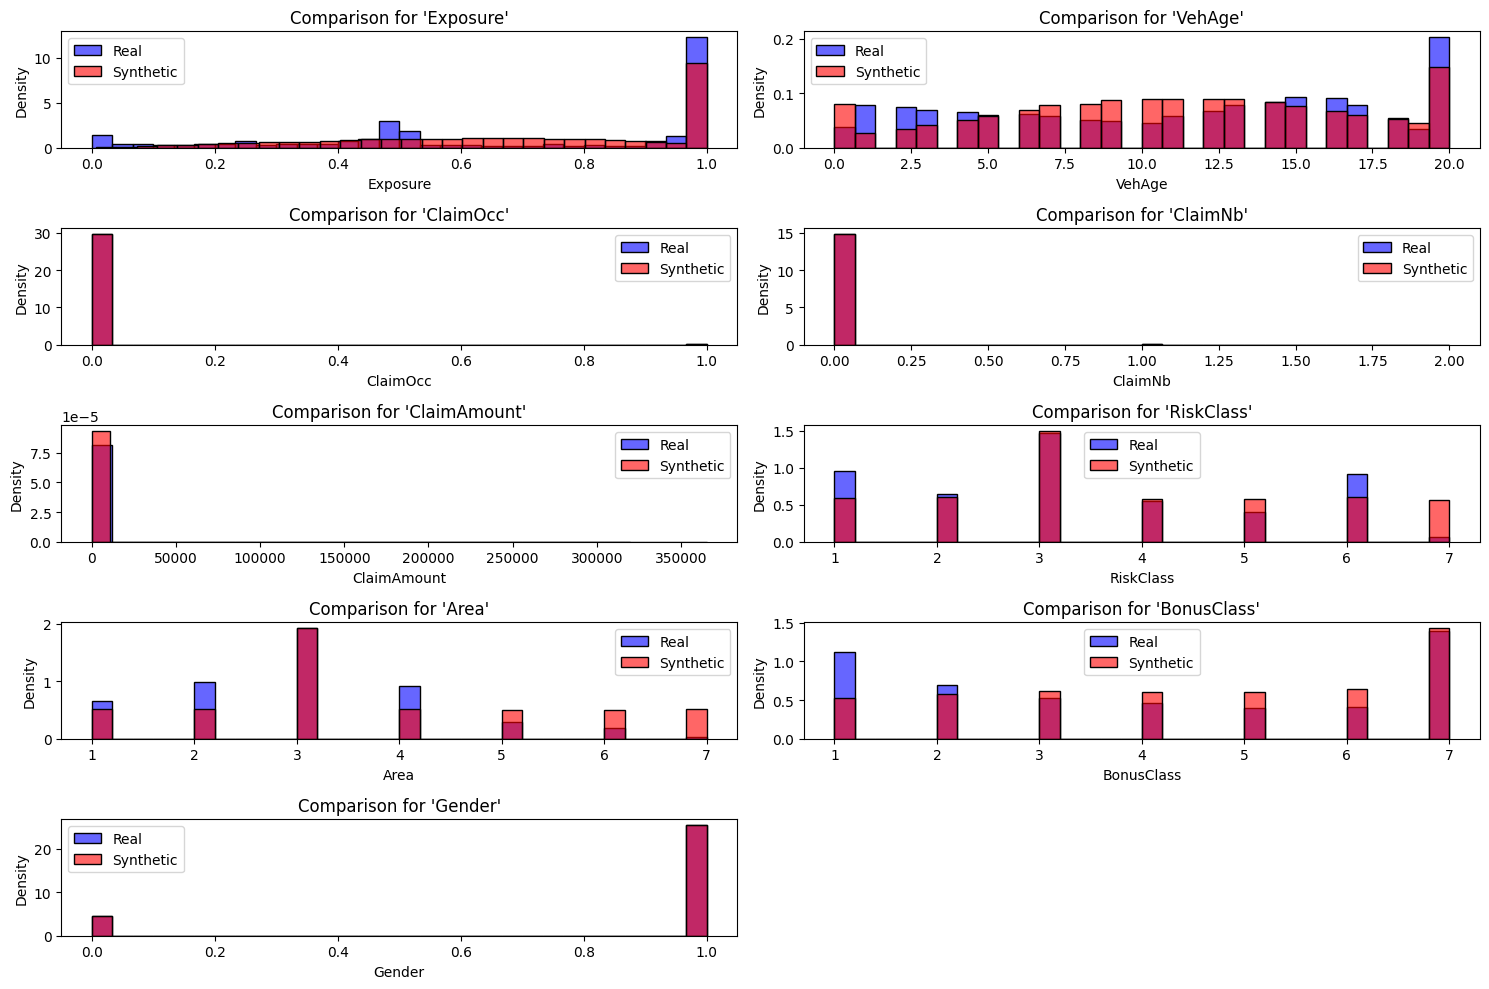

In [ ]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=new_samples_df,
    columns=['Exposure','VehAge','ClaimOcc','ClaimNb', 'ClaimAmount', 'RiskClass', 'Area','BonusClass','Gender'],
    kind='hist'
)


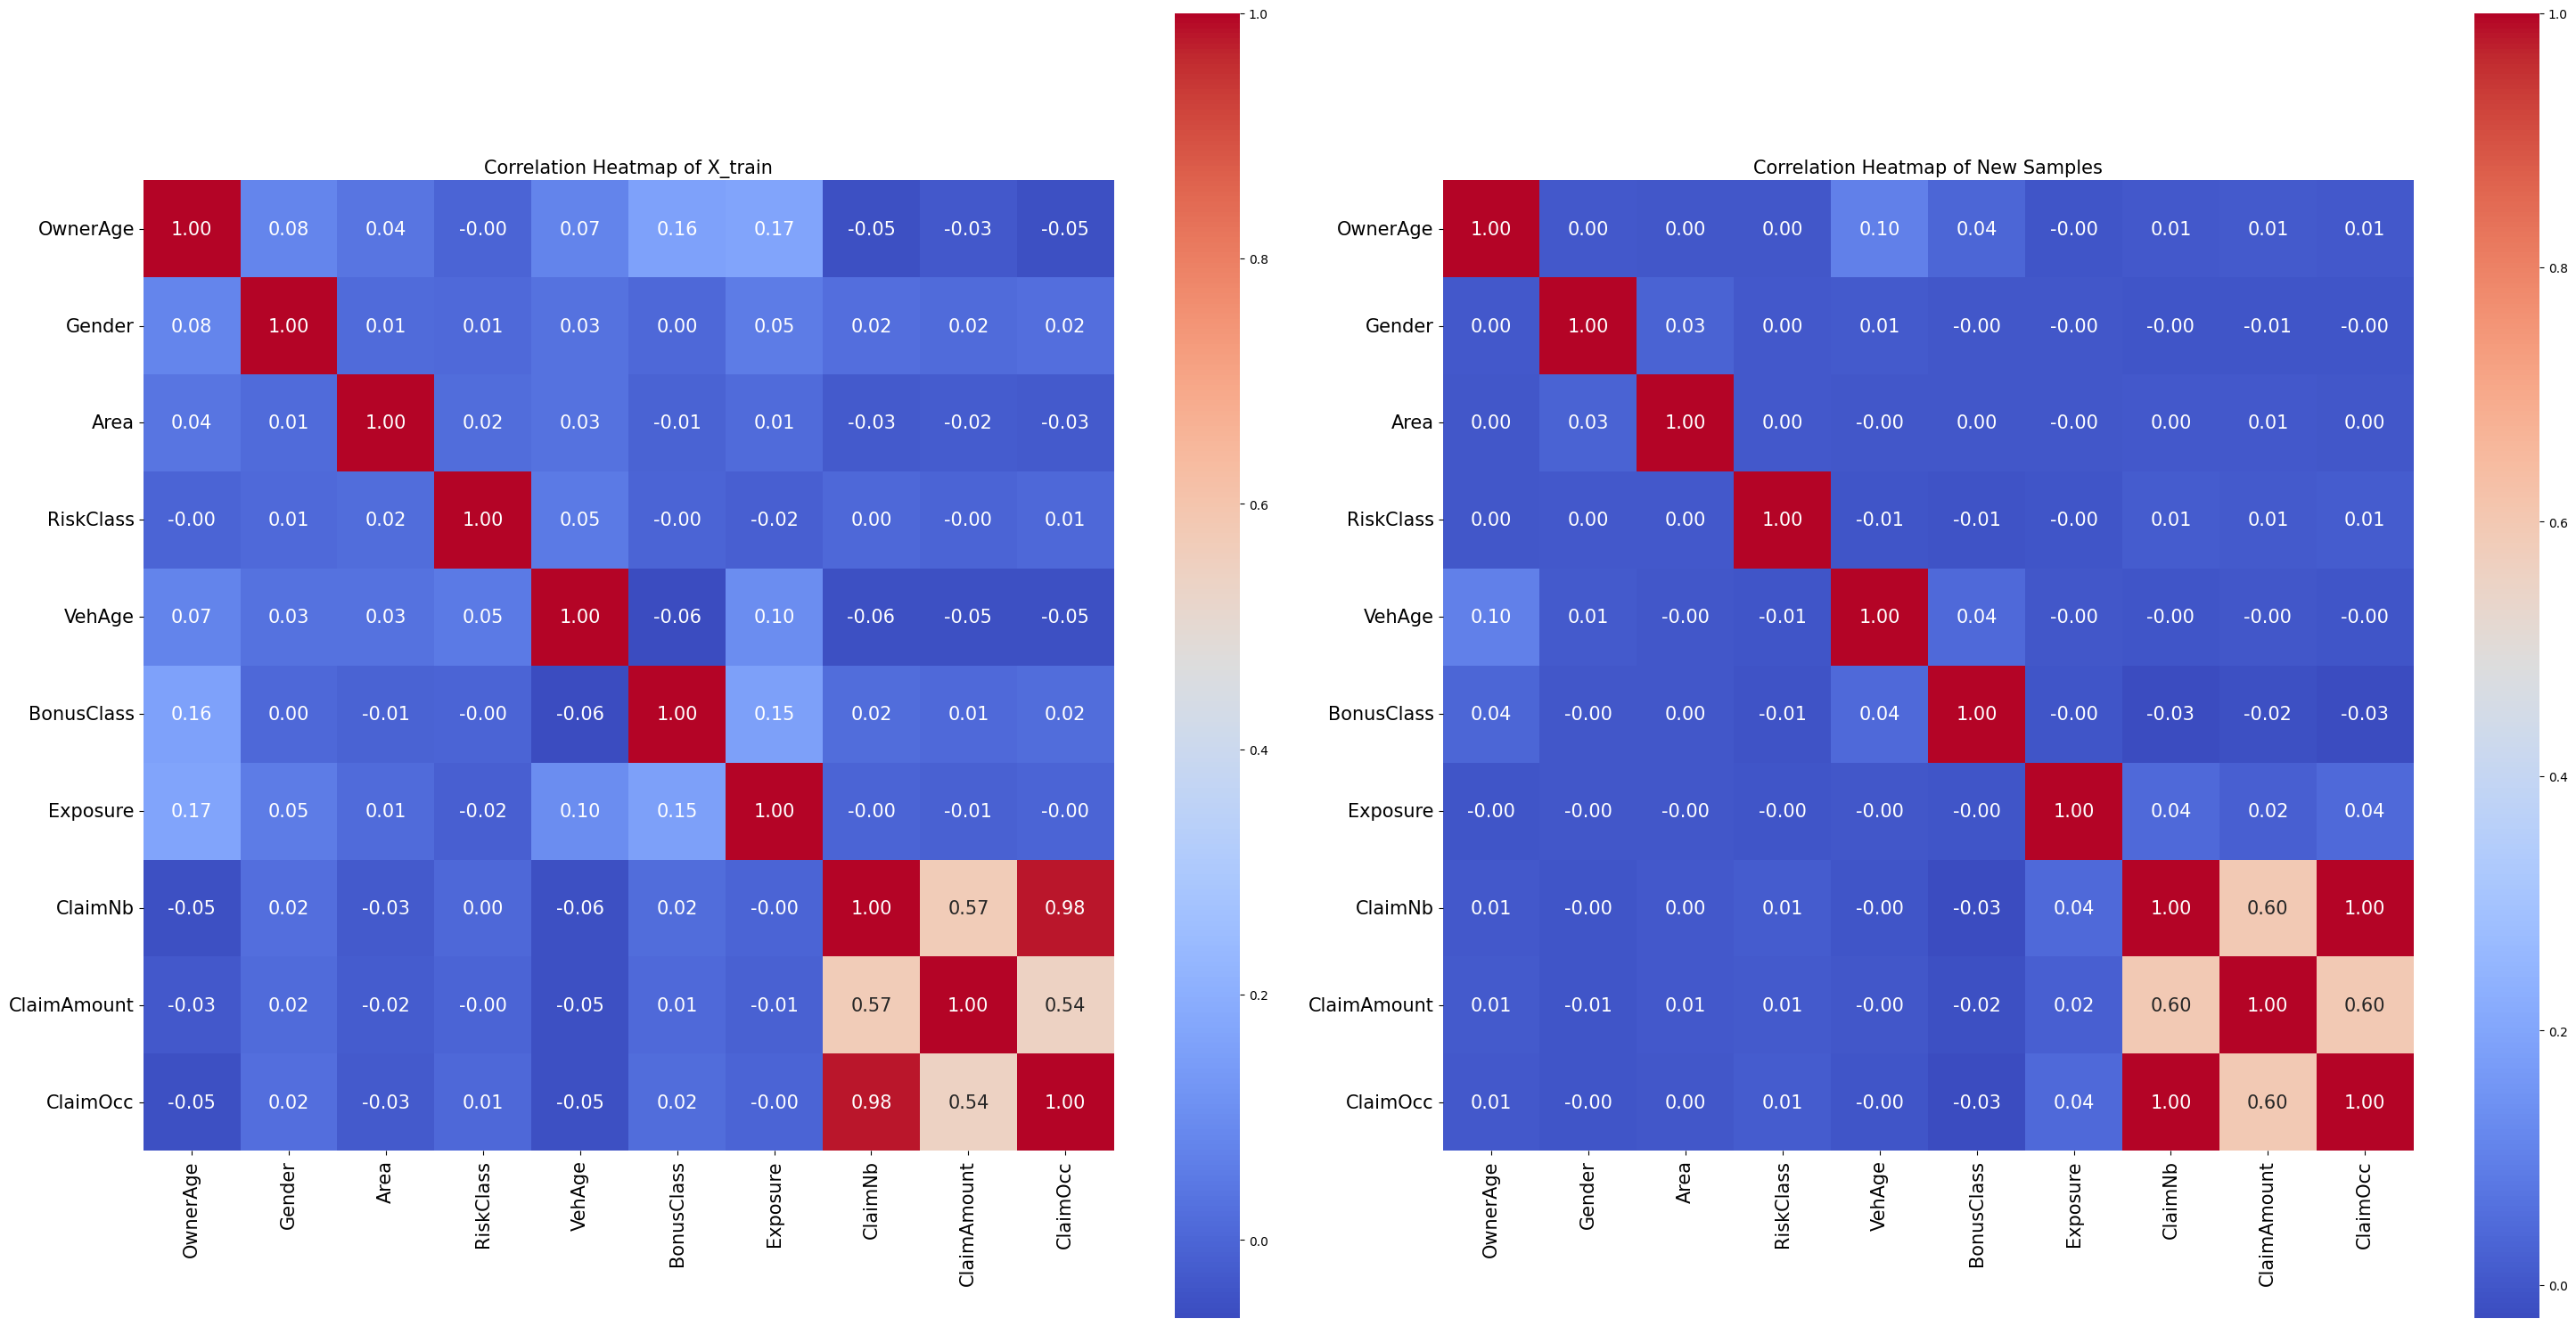

In [ ]:
# Compute correlation matrices
corr_matrix_X_train = X_train.corr()
corr_matrix_new_samples = new_samples_df.corr()

# Set figure size
plt.figure(figsize=(30,15))

# a subplot grid
# Parameters (1, 2, 1) implies 1 row, 2 columns, and this plot is the 1st plot.
plt.subplot(1, 2, 1) # Subplot 1
sns.heatmap(corr_matrix_X_train, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of X_train', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# another subplot for the second heatmap
plt.subplot(1, 2, 2) # Subplot 2
sns.heatmap(corr_matrix_new_samples, square=True, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 15})
plt.title('Correlation Heatmap of New Samples', size=15)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=90,fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()

### Statistical Analysis

In [ ]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for OwnerAge: Statistic=0.0791665052868043, P-value=3.3961217179150247e-141
KS Test for Gender: Statistic=0.003137224524574933, P-value=0.9605684747430727
KS Test for Area: Statistic=0.20349355126069946, P-value=0.0
KS Test for RiskClass: Statistic=0.10097215229094847, P-value=1.2892173226774862e-229
KS Test for VehAge: Statistic=0.07151709981021726, P-value=2.8046960921031155e-115
KS Test for BonusClass: Statistic=0.14179480227739263, P-value=0.0
KS Test for Exposure: Statistic=0.14988961617413532, P-value=0.0
KS Test for ClaimNb: Statistic=0.0004647740036407555, P-value=1.0
KS Test for ClaimAmount: Statistic=0.001007010341221637, P-value=1.0
KS Test for ClaimOcc: Statistic=0.0004647740036407555, P-value=1.0


### PCA Analysis

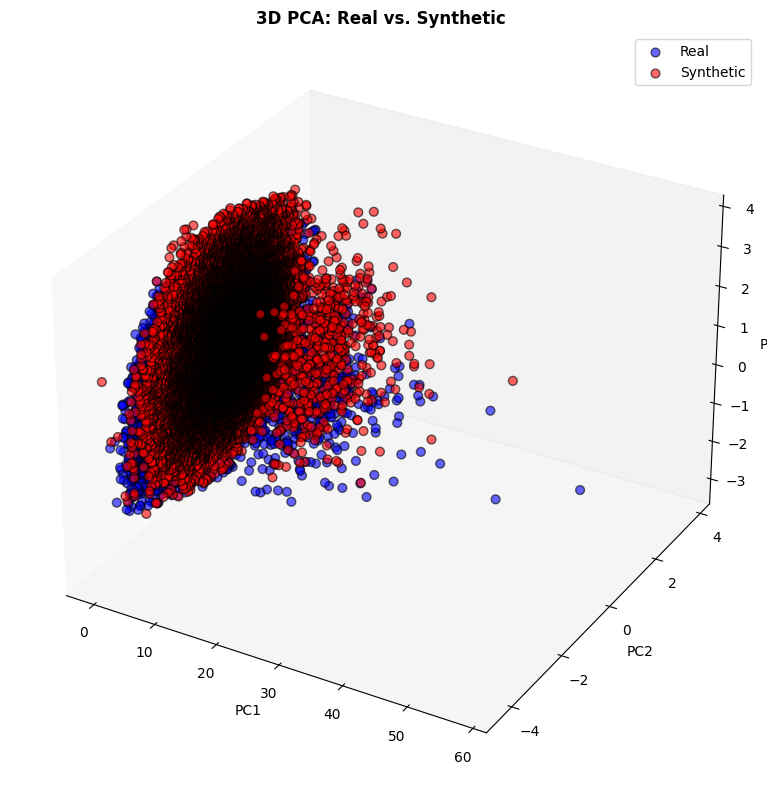

In [ ]:
pca_visual_comparison_3d(X_train, new_samples_df, var='d2')

### UMAP Analysis

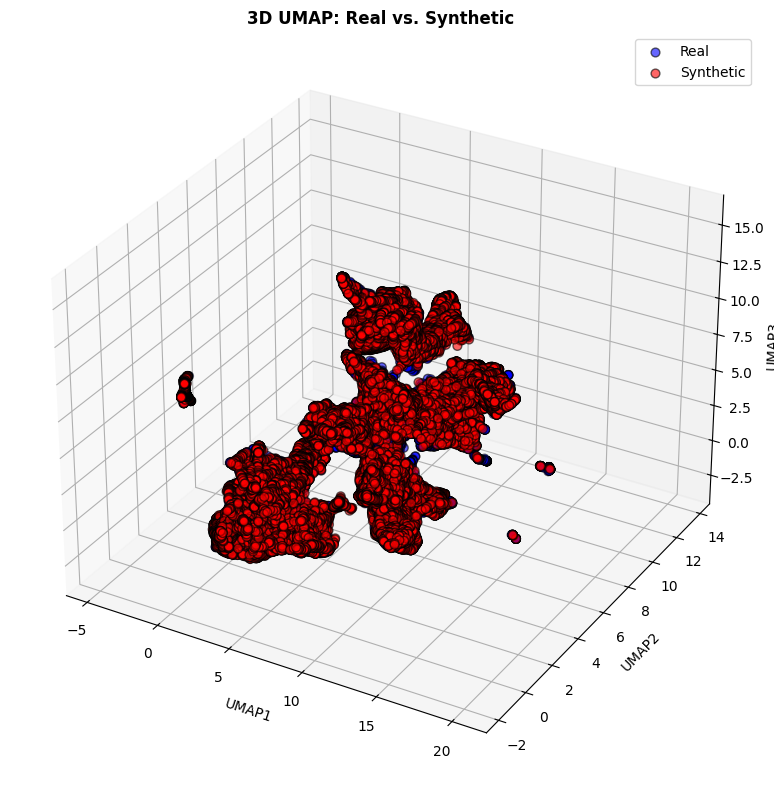

In [ ]:
umap_visual_comparison_3d(X_train, new_samples_df, var='d2')

### GLM Frequency Analysis

In [ ]:
# Baseline frequency model
results_frequency_3 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")


Fold 1 Poisson Deviance Score: 0.2113
Fold 2 Poisson Deviance Score: 0.2744
Fold 3 Poisson Deviance Score: 0.3212
Fold 4 Poisson Deviance Score: 0.3262
Fold 5 Poisson Deviance Score: 0.2611
Average cross-validation Poisson Deviance Score: 0.2788
Standard Deviation of CV Scores: 0.0423
Train Poisson Deviance: 0.2788
Test Poisson Deviance: 0.4368


In [ ]:
# Using synthetic sample data with exposure clipping
results_frequency_4 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 0.1196
Fold 2 Poisson Deviance Score: 0.1681
Fold 3 Poisson Deviance Score: 0.1206
Fold 4 Poisson Deviance Score: 0.1231
Fold 5 Poisson Deviance Score: 0.1390
Average cross-validation Poisson Deviance Score: 0.1341
Standard Deviation of CV Scores: 0.0184
Train Poisson Deviance: 0.1339
Test Poisson Deviance: 0.4886


### GLM Cost Analysis

In [ ]:
results_cost_3 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.8636
Fold 2 Gamma Deviance Score: 1.8794
Fold 3 Gamma Deviance Score: 1.6971
Fold 4 Gamma Deviance Score: 1.8394
Fold 5 Gamma Deviance Score: 1.8494
Average cross-validation Gamma Deviance Score: 1.825777294896016
Standard Deviation of CV Scores: 0.06574128033743543
Train Gamma Deviance: 1.7615
Test Gamma Deviance: 1.7251


In [ ]:
results_cost_4 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)

Fold 1 Gamma Deviance Score: 2.2640
Fold 2 Gamma Deviance Score: 2.4098
Fold 3 Gamma Deviance Score: 1.8407
Fold 4 Gamma Deviance Score: 2.4125
Fold 5 Gamma Deviance Score: 1.9475
Average cross-validation Gamma Deviance Score: 2.1749204955592094
Standard Deviation of CV Scores: 0.23788628226541694
Train Gamma Deviance: 2.1249
Test Gamma Deviance: 1.9582


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


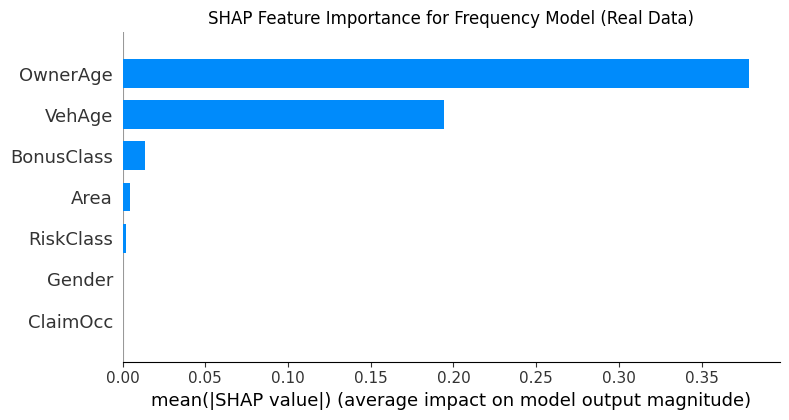


--- SHAP Feature Importance for Severity Model ---


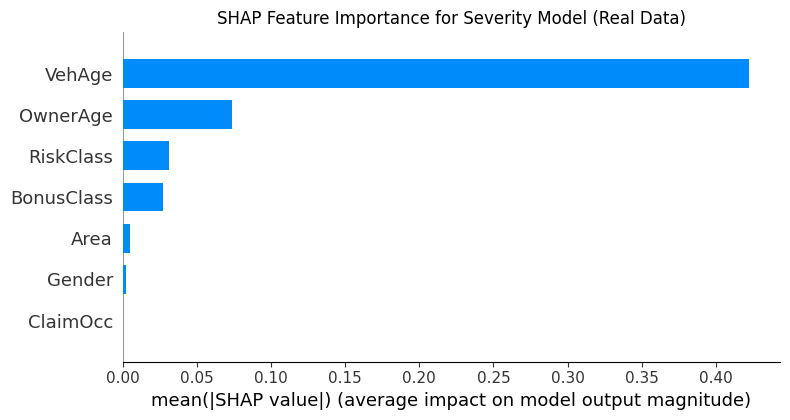

In [ ]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


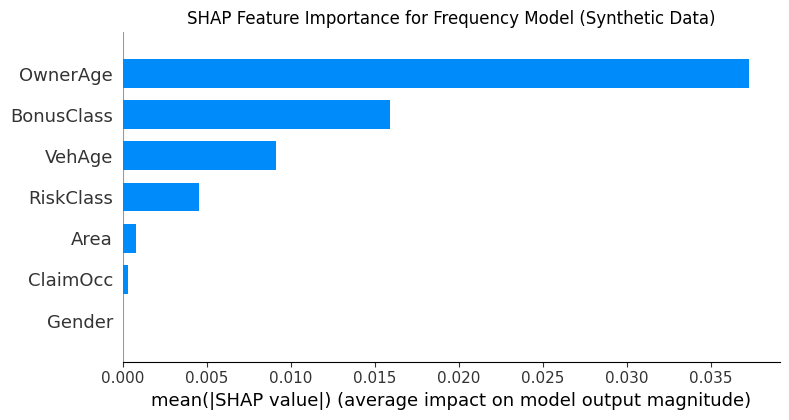


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


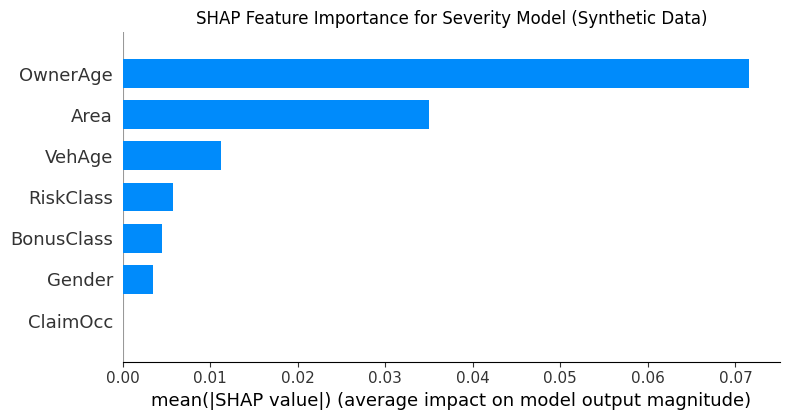

In [ ]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Results

In [ ]:
# The dictionary dataset 1
metrics_dict_1 = results_frequency_1[1]
mpd_train_1 = metrics_dict_1['mpd_train']
mpd_test_1 = metrics_dict_1['mpd_test']
print(f"mpd_train_1: {mpd_train_1}")
print(f"mpd_test_1: {mpd_test_1}")

mpd_train_1: 1.4344568519034897
mpd_test_1: 1.741190103494106


In [ ]:
# The dictionary synthetic dataset 1
metrics_dict_2 = results_frequency_2[1]
mpd_train_2 = metrics_dict_2['mpd_train']
mpd_test_2 = metrics_dict_2['mpd_test']
print(f"mpd_train_2: {mpd_train_2}")
print(f"mpd_test_2: {mpd_test_2}")

mpd_train_2: 1.0341871761583075
mpd_test_2: 1.7410053388546796


In [ ]:
# The dictionary dataset 2
metrics_dict_3 = results_frequency_3[1]
mpd_train_3 = metrics_dict_3['mpd_train']
mpd_test_3 = metrics_dict_3['mpd_test']
print(f"mpd_train_3: {mpd_train_3}")
print(f"mpd_test_3: {mpd_test_3}")

mpd_train_3: 0.2787767739809314
mpd_test_3: 0.4367935890535355


In [ ]:
# The dictionary synthetic dataset 2
metrics_dict_4 = results_frequency_4[1]
mpd_train_4 = metrics_dict_4['mpd_train']
mpd_test_4 = metrics_dict_4['mpd_test']
print(f"mpd_train_4: {mpd_train_4}")
print(f"mpd_test_4: {mpd_test_4}")

mpd_train_4: 0.1338674014687812
mpd_test_4: 0.488581905879356


In [ ]:
# The dictionary dataset 1
mgd_train_1 = results_cost_1['mgd_train']
mgd_test_1 = results_cost_1['mgd_test']
print(f"mgd_train_1: {mgd_train_1}")
print(f"mgd_test_1: {mgd_test_1}")

mgd_train_1: 1.5508741472884893
mgd_test_1: 1.7221300040077396


In [ ]:
# The dictionary synthetic dataset 1
mgd_train_2 = results_cost_2['mgd_train']
mgd_test_2 = results_cost_2['mgd_test']
print(f"mgd_train_2: {mgd_train_2}")
print(f"mgd_test_2: {mgd_test_2}")

mgd_train_2: 1.5110448478868477
mgd_test_2: 1.7965595694560597


In [ ]:
# The dictionary dataset 2
mgd_train_3 = results_cost_3['mgd_train']
mgd_test_3 = results_cost_3['mgd_test']
print(f"mgd_train_3: {mgd_train_3}")
print(f"mgd_test_3: {mgd_test_3}")

mgd_train_3: 1.7615204909151378
mgd_test_3: 1.7250831816188326


In [ ]:
# The dictionary synthetic dataset 2
mgd_train_4 = results_cost_4['mgd_train']
mgd_test_4 = results_cost_4['mgd_test']
print(f"mgd_train_4: {mgd_train_4}")
print(f"mgd_test_4: {mgd_test_4}")

mgd_train_4: 2.1248979174124925
mgd_test_4: 1.9582351772812885


In [ ]:
# Create the DataFrame
results_df1 = {
    'mpd_train': mpd_train_1,
    'mpd_test': mpd_test_1,
    'mgd_train': mgd_train_1,
    'mgd_test': mgd_test_1,
}
results_df2 = {
    'mpd_train': mpd_train_2,
    'mpd_test': mpd_test_2,
    'mgd_train': mgd_train_2,
    'mgd_test': mgd_test_2,
}
results_df3 = {
    'mpd_train': mpd_train_3,
    'mpd_test': mpd_test_3,
    'mgd_train': mgd_train_3,
    'mgd_test': mgd_test_3,
}
results_df4 = {
    'mpd_train': mpd_train_4,
    'mpd_test': mpd_test_4,
    'mgd_train': mgd_train_4,
    'mgd_test': mgd_test_4,
}
d1=pd.DataFrame(results_df1, index=['dataset 1'])
d2=pd.DataFrame(results_df2, index=['synthetic dataset 1'])
d3=pd.DataFrame(results_df3, index=['dataset 2'])
d4=pd.DataFrame(results_df4, index=['synthetic dataset 2'])
df_tot= pd.concat([d1,d2,d3,d4])
df_tot

,mpd_train,mpd_test,mgd_train,mgd_test
dataset 1,1.434457,1.741190,1.550874,1.722130
synthetic dataset 1,1.034187,1.741005,1.511045,1.796560
dataset 2,0.278777,0.436794,1.761520,1.725083
synthetic dataset 2,0.133867,0.488582,2.124898,1.958235


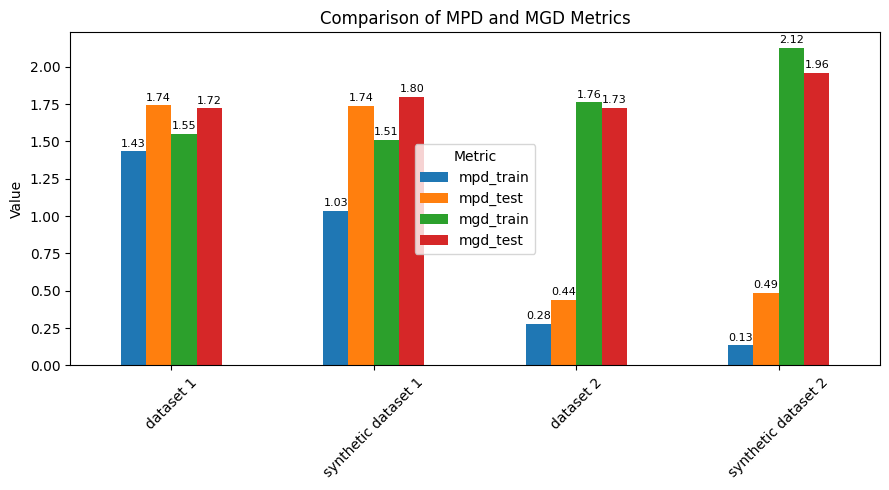

In [ ]:
# Set up the plot
ax = df_tot.plot(kind='bar', figsize=(9, 5))

# Labels and title
plt.title('Comparison of MPD and MGD Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Add value labels with smaller font size
for container in ax.containers:
    labels = ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)
    for label in labels:
        label.set_fontsize(8)

plt.tight_layout()
plt.show()

